In [1]:
import sys
import random
import itertools
import logging
from pprint import pprint
from collections import Counter

import numpy as np
import tensorflow as tf
import tensorflow.keras as ks
import matplotlib.pyplot as plt

from gnn_teacher_student.main import StudentTeacherExplanationAnalysis
from gnn_teacher_student.main import NoLoss, ExplanationLoss
from gnn_teacher_student.students import StudentTemplate, SimpleAttentionStudent
from gnn_teacher_student.data import generate_color_pairs_dataset
from gnn_teacher_student.visualization import (draw_colors_graph,
                                               draw_graph_node_importances,
                                               draw_graph_edge_importances)

# Disabling all kinds of warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn = lambda *args, **kwargs: 0
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Enable eager execution
tf.compat.v1.enable_eager_execution()

DATASET SUMMARY
Number of Graphs: 1000
--------------------------------------------------------------
Min Graph Size: 5
Max Graph Size: 30
--------------------------------------------------------------
Number of distinct Colors: 5
Color Distribution:
  Color (1.0, 0.0, 1.0): 3770 total nodes (19.1%)
  Color (0.0, 1.0, 0.0): 4229 total nodes (21.4%)
  Color (1.0, 0.0, 0.0): 4164 total nodes (21.1%)
  Color (0.0, 0.0, 1.0): 3728 total nodes (18.9%)
  Color (1.0, 1.0, 0.0): 3838 total nodes (19.5%)
--------------------------------------------------------------
GT Labels: Total number of color pairs
Label Distribution:
   Label 1: 467   (46.7%)
   Label 2: 311   (31.1%)
   Label 3: 152   (15.2%)
   Label 4: 47    (4.7%)
   Label 5: 18    (1.8%)
   Label 6: 5     (0.5%)


Text(0.5, 1.0, 'Example Graph from the Dataset')

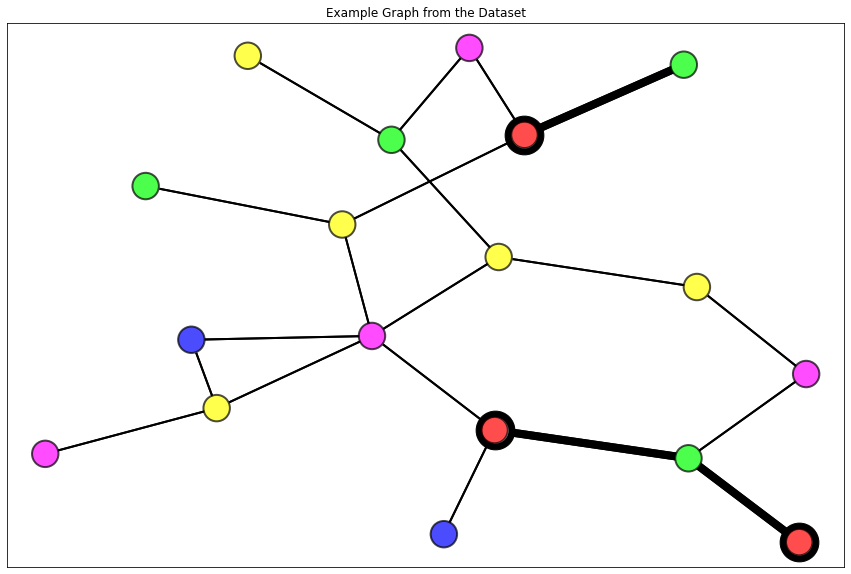

In [2]:
# ~ Generating the dataset

dataset = generate_color_pairs_dataset(
    length=1000,
    node_count_cb=lambda: random.randint(5, 30),
    additional_edge_count_cb=lambda: random.randint(1, 3),
    colors=[
        (1, 0, 0),  # red
        (0, 1, 0),  # green
        (0, 0, 1),  # blue
        (1, 1, 0),  # yellow
        (1, 0, 1),  # magenta
    ],
    exclude_empty=True
)

# ~ Printing information about dataset
graph_sizes = [len(g['node_indices']) for g in dataset]
graph_labels = [int(g['graph_labels']) for g in dataset]
graph_labels_counter = Counter(graph_labels)

graph_colors = [[tuple(color) for color in g['node_attributes']] for g in dataset]
graph_colors_combined = list(itertools.chain(*graph_colors))
graph_colors_counter = Counter(graph_colors_combined)

print('DATASET SUMMARY')
print('==============================================================')
print(f'Number of Graphs: {len(dataset)}')
print('--------------------------------------------------------------')
print(f'Min Graph Size: {min(graph_sizes)}')
print(f'Max Graph Size: {max(graph_sizes)}')
print('--------------------------------------------------------------')
print(f'Number of distinct Colors: {len(graph_colors_counter)}')
print(f'Color Distribution:')
for color, count in graph_colors_counter.items():
    percentage = count / len(graph_colors_combined)
    print(f'  Color {color}: {count} total nodes ({percentage*100:.1f}%)')
print('--------------------------------------------------------------')
print('GT Labels: Total number of color pairs')
print('Label Distribution:')
for label, count in sorted(graph_labels_counter.items(), key=lambda i: i[0]):
    percentage = count / len(graph_labels)
    print(f'   Label {label}: {count:<5} ({percentage*100:.1f}%)')

# ~ Plotting an example graph

g = dataset[0]

fig, ax_g = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
fig.patch.set_facecolor('white')

ax_g, graph = draw_colors_graph(
    g=g,
    ax=ax_g,
    node_size=700,
    edge_size=2,
    alpha=0.7
)
ax_g = draw_graph_node_importances(
    node_importances=g['node_importances'],
    graph=graph,
    ax=ax_g,
    size=1500
)
ax_g = draw_graph_edge_importances(
    edge_indices=g['edge_indices'],
    edge_importances=g['edge_importances'],
    graph=graph,
    ax=ax_g,
    size=8
)

ax_g.set_title('Example Graph from the Dataset')

In [3]:
attention_student = StudentTemplate(
    student_class=SimpleAttentionStudent,
    student_name='attention_student',
    units=2,
    attention_units=3,
    activation='kgcnn>leaky_relu',
    attention_activation='tanh',
)

student_teacher_analysis = StudentTeacherExplanationAnalysis(
    student_template=attention_student,
    epochs=20,
    batch_size=32,
    prediction_metric=ks.metrics.MeanSquaredError(),
    explanation_metric=ks.metrics.MeanAbsoluteError()
)

student_teacher_analysis.logger.addHandler(logging.StreamHandler(stream=sys.stdout))

_dataset = {field: [g[field] for g in dataset] for field in dataset[0].keys()}

with tf.device('/cpu:0'):
    results = student_teacher_analysis.fit(
        dataset=_dataset,
        train_split=0.8,
        variant_kwargs={
            'exp': {
                'loss': [
                    ks.losses.MeanSquaredError(),
                    ExplanationLoss(),
                    ExplanationLoss()
                ],
                'loss_weights': [1, 1, 1],
                'callbacks': []
            },
            'ref': {
                'loss': [
                    ks.losses.MeanSquaredError(),
                    NoLoss(),
                    NoLoss(),
                ],
                'loss_weights': [1, 1, 1],
                'callbacks': []
            }
        },
        log_progress=5
    )

starting student training "attention_student:exp" [LOSS:] prediction="mean_squared_error*1" node_importance="explanation_loss*1" edge_importance="explanation_loss*1" [BATCHING:] batch_size=1 supports_batching="False" [MODEL:] parameters=62 [TRAINING:] epochs=20 optimizer=Adam dataset_size=6) 
   epoch 0    : value=1.0 elapsed_time=7.5s
   epoch 5    : value=0.6 elapsed_time=16.8s
   epoch 10   : value=0.4 elapsed_time=26.0s
   epoch 15   : value=0.3 elapsed_time=35.3s
starting student training "attention_student:ref" [LOSS:] prediction="mean_squared_error*1" node_importance="no_loss*1" edge_importance="no_loss*1" [BATCHING:] batch_size=1 supports_batching="False" [MODEL:] parameters=62 [TRAINING:] epochs=20 optimizer=Adam dataset_size=6) 
   epoch 0    : value=0.8 elapsed_time=5.1s
   epoch 5    : value=0.8 elapsed_time=11.9s
   epoch 10   : value=0.8 elapsed_time=18.6s
   epoch 15   : value=0.7 elapsed_time=25.3s
student teacher analysis complete after 2.0 minutes


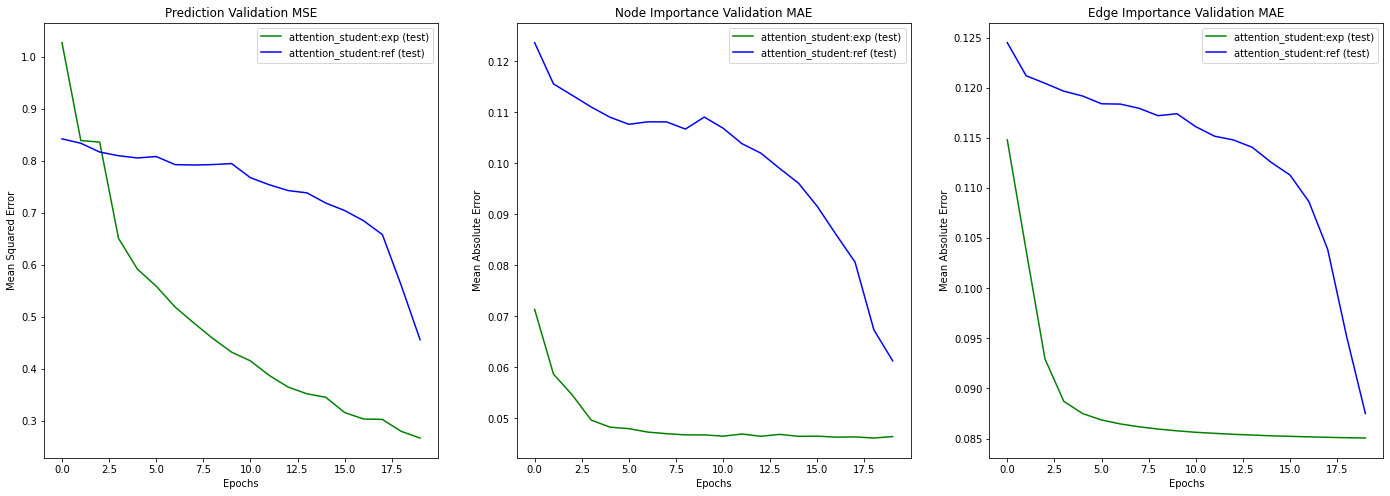

In [4]:
fig, (ax_pred, ax_node, ax_edge) = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
fig.patch.set_facecolor('white')

variant_color_map = {
    'exp': 'green',
    'ref': 'blue'
}

variant_alpha_map = {
    'exp': 1.0,
    'ref': 1.0
}

# ~ Plotting prediction validation error
student_teacher_analysis.plot_metrics(
    ax=ax_pred,
    results=results,
    metric='prediction',
    student_variant_color_map=variant_color_map,
    student_variant_alpha_map=variant_alpha_map
)
ax_pred.set_title('Prediction Validation MSE')
ax_pred.set_xlabel('Epochs')
ax_pred.set_ylabel('Mean Squared Error')
ax_pred.legend()

# ~ Plotting the node importance validation error
student_teacher_analysis.plot_metrics(
    ax_node,
    results=results,
    metric='node_importance',
    student_variant_color_map=variant_color_map,
    student_variant_alpha_map=variant_alpha_map
)
ax_node.set_title('Node Importance Validation MAE')
ax_node.set_xlabel('Epochs')
ax_node.set_ylabel('Mean Absolute Error')
ax_node.legend()

# ~ Plotting the edge importance validation error
student_teacher_analysis.plot_metrics(
    ax_edge,
    results=results,
    metric='edge_importance',
    student_variant_color_map=variant_color_map,
    student_variant_alpha_map=variant_alpha_map
)
ax_edge.set_title('Edge Importance Validation MAE')
ax_edge.set_xlabel('Epochs')
ax_edge.set_ylabel('Mean Absolute Error')
ax_edge.legend()


(0.5, 2.5)

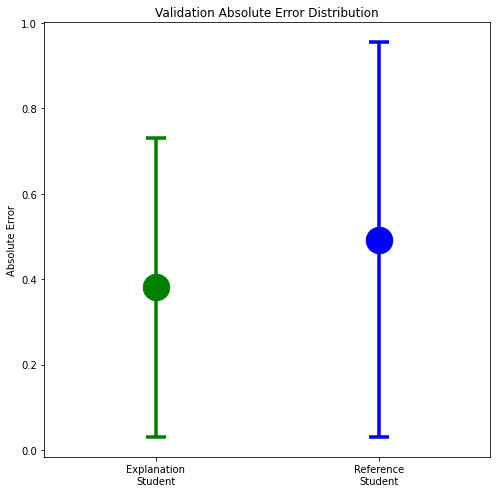

In [5]:
fig, (ax_final) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
fig.patch.set_facecolor('white')

student_teacher_analysis.plot_final(
    ax_final,
    results=results,
    student_variants=['exp', 'ref'],
    error_func=lambda y_true, y_pred: np.abs(y_true - y_pred[0]),
    student_variant_color_map=variant_color_map,
)
ax_final.set_title('Validation Absolute Error Distribution')
ax_final.set_xticklabels(['Explanation\nStudent', 'Reference\nStudent'])
ax_final.set_ylabel('Absolute Error')
ax_final.set_xlim([0.5, 2.5])

In [6]:
stat_results = student_teacher_analysis.calc_final(
    results=results,
    student_variants=['exp', 'ref'],
    error_func=lambda y_true, y_pred: np.abs(y_true - y_pred[0]),
)
pprint(stat_results)


{('exp', 'ref'): {'avg_error_div': -0.111359775,
                  'exp_avg_error': 0.38079247,
                  'ref_avg_error': 0.49215224,
                  'wilcoxon_result': WilcoxonResult(statistic=5518.0, pvalue=3.2057549633720465e-08)}}
